### DeepFM :https://github.com/shenweichen/DeepCTR-Torch
### Paper : https://www.ijcai.org/proceedings/2017/0239.pdf
 * DeepFM do not need domain knowledge because this model Don't use feature engineering
 * So We run it!

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import gc

plt.style.use('ggplot')

import warnings as w
w.filterwarnings(action='ignore')
pd.set_option('display.max_columns',None)

In [2]:
dtype={'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.str,
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str)
      }
num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [3]:
train = pd.read_csv("../input/avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date, dtype=dtype, skiprows=skip_values)
test = pd.read_csv('../input/avazu-ctr-prediction/test.gz')
submission = pd.read_csv('../input/avazu-ctr-prediction/sampleSubmission.gz')
print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

Train dataset: (5000000, 24)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


### Feature Expalin
  1. id : personal_id
  2. click : target
  3. hour : datetime
  4. C1 : anonymized categorical variable
  5. banner_pos : showing banner
  6. site domain
  7. site_category 
  8. app_id 
  9. add_category
  10. device_id 
  11. device_ip
  12. device_model
  13. device_type
  14. device_conn_type
  15. C14 ~ C21 : anonymized categorical variables

In [4]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000169349117863715,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
1,10001868339616595934,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5d877109,8f5c9827,1,0,17747,320,50,1974,2,39,100019,33
2,10002028568167339219,0,2014-10-21,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157
3,10003539039235338011,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a4f47b2e,8a4875bd,1,0,15699,320,50,1722,0,35,100084,79
4,10004670021948955159,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,a2d12b33,607e78f2,1,0,20366,320,50,2333,0,39,-1,157


In [5]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,10fb085b,1f0bc64f,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221


In [6]:
train.isna().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

0    4151984
1     848016
Name: click, dtype: int64


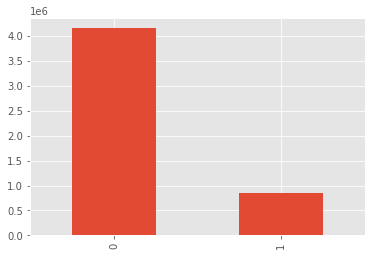

In [7]:
train.click.value_counts().plot(kind='bar')
print(train.click.value_counts())

## Target feature data imbalance

In [8]:
train.banner_pos.value_counts()

0    3600946
1    1389977
7       5473
2       1638
4        957
5        749
3        260
Name: banner_pos, dtype: int64

<AxesSubplot:xlabel='banner_pos', ylabel='count'>

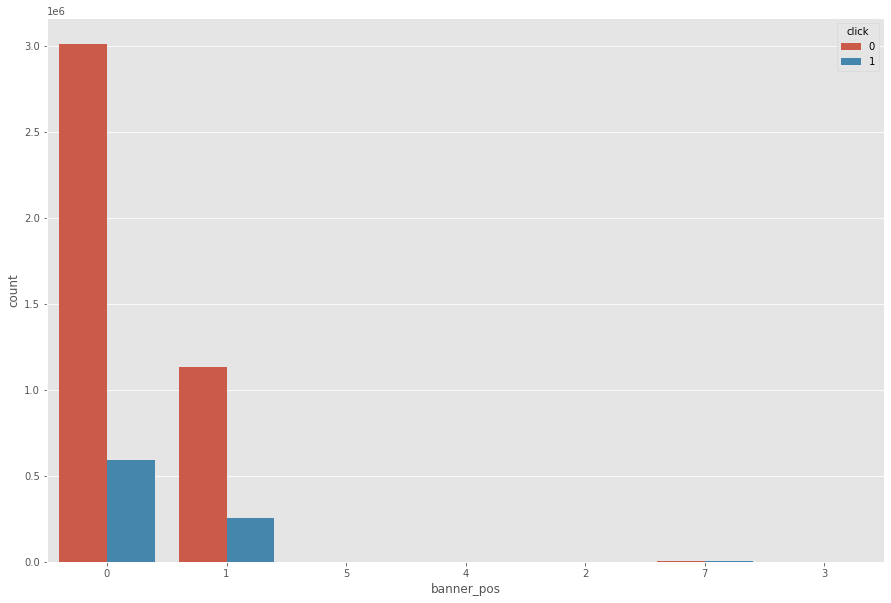

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(x='banner_pos',hue='click',data=train)

### Banner pos is not effienct increasing user click  

<AxesSubplot:xlabel='hour', ylabel='count'>

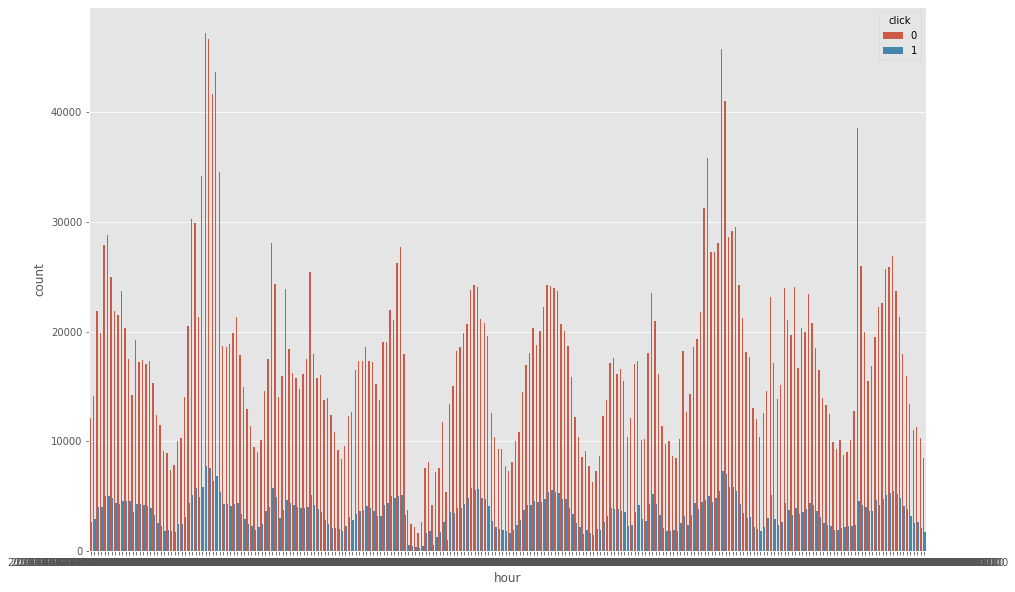

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(x='hour',hue='click',data=train)

### The date is too long to identify characteristics, so sample data is taken to run a sample survey

In [11]:
ex_data = train[train.hour < '2014-10-22']
ex_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000169349117863715,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
1,10001868339616595934,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5d877109,8f5c9827,1,0,17747,320,50,1974,2,39,100019,33
2,10002028568167339219,0,2014-10-21,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157
3,10003539039235338011,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a4f47b2e,8a4875bd,1,0,15699,320,50,1722,0,35,100084,79
4,10004670021948955159,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,a2d12b33,607e78f2,1,0,20366,320,50,2333,0,39,-1,157


<AxesSubplot:xlabel='hour', ylabel='count'>

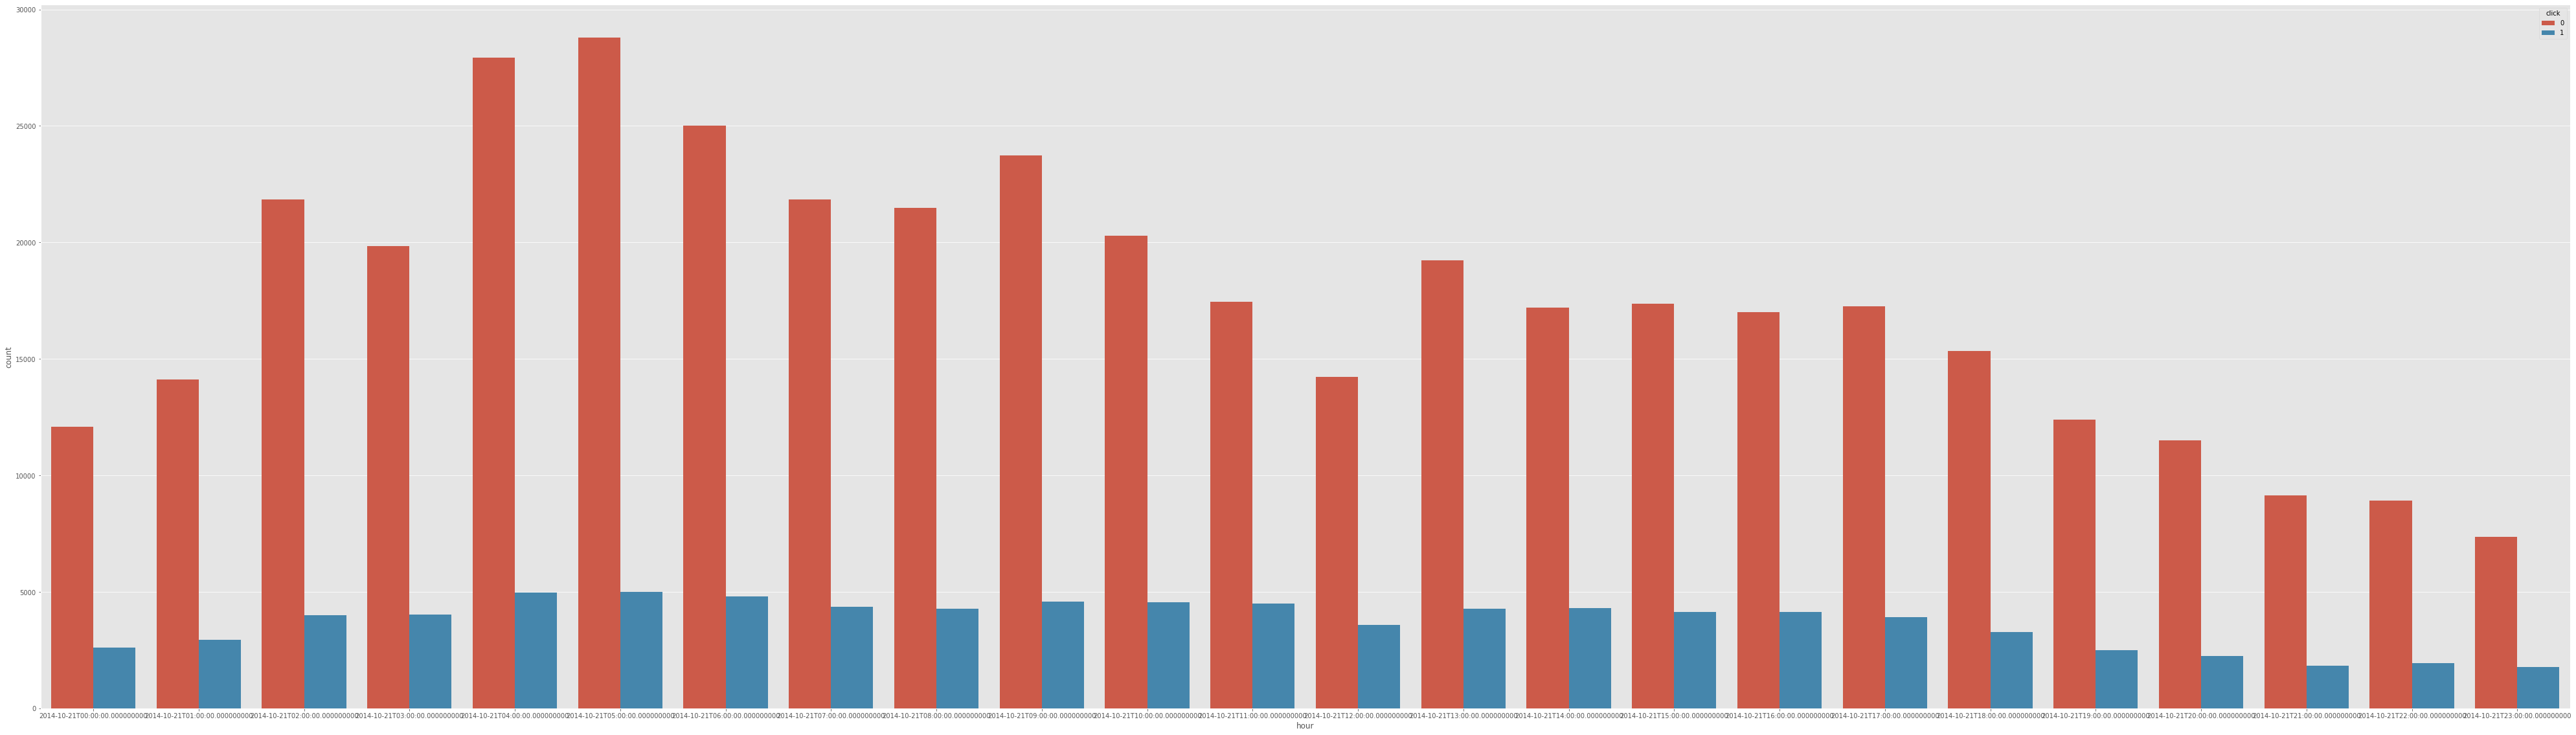

In [12]:
plt.figure(figsize=(70,20))
sns.countplot(x='hour',hue='click',data=ex_data)

### Clicks don't seem to be affected by time

In [13]:
del ex_data
gc.collect()

38

In [14]:
train.set_index('hour',inplace=True)

In [15]:
test.set_index('hour',inplace=True)

In [16]:
train.head()

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,,
2014-10-21,10000169349117863715,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2014-10-21,10001868339616595934,0,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5d877109,8f5c9827,1,0,17747,320,50,1974,2,39,100019,33
2014-10-21,10002028568167339219,0,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157
2014-10-21,10003539039235338011,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a4f47b2e,8a4875bd,1,0,15699,320,50,1722,0,35,100084,79
2014-10-21,10004670021948955159,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,a2d12b33,607e78f2,1,0,20366,320,50,2333,0,39,-1,157


### sparse feature
 * C1
 * banner_pos
 * site_id
 * site_domain
 * site_category
 * app_id
 * app_domain
 * app_category
 * device_id
 * device_ip
 * device_model
 * device_type
 * device_conn_type

### Dense feature
 * C14 ~ c21

In [17]:
!pip install deepctr_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 492.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 23.9 MB/s eta 0:00:0000:0100:01
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77061 sha256=17b8f2078045c33a958ab2baca95769f8207c17d179aa4d5aaa7344f40bd6ca9
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing in

In [18]:
import torch
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

In [19]:
data = train

In [20]:
sparse_features = train.iloc[::,2:14].columns.values.tolist()
dense_features = train.iloc[::,15:].columns.values.tolist()
sparse_features.append('id')
target = ['click']

In [21]:
test.head()

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,
14103100,1.000017e+19,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
14103100,1.000018e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51
14103100,1.000055e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,10fb085b,1f0bc64f,1,0,22676,320,50,2616,0,35,100083,51
14103100,1.000109e+19,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61
14103100,1.000138e+19,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221


In [22]:
test_sparse_features = test.iloc[::,0:14].columns.values.tolist()
test_dense_features = test.iloc[::,14:].columns.values.tolist()

In [23]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
scaler = MinMaxScaler(feature_range=(0,1))
encoder = LabelEncoder()

In [24]:
for feat in sparse_features:
    data[feat] = encoder.fit_transform(data[feat])
data[dense_features] = scaler.fit_transform(data[dense_features])

In [25]:
for feat in test_sparse_features:
    test[feat] = encoder.fit_transform(test[feat])
test[dense_features] = scaler.fit_transform(test[test_dense_features])

In [26]:
fixlen_feature_columns = [SparseFeat(feat,data[feat].nunique()) 
                          for feat in sparse_features] + [DenseFeat(feat,1,)
                                                         for feat in dense_features]

In [27]:
# fixlen_feature_columns = [SparseFeat(feat,data[feat].nunique()) 
#                           for feat in sparse_features] + [DenseFeat(feat,1,)
#                                                          for feat in dense_features]

In [28]:
fixlen_feature_columns

[SparseFeat(name='C1', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C1', group_name='default_group'),
 SparseFeat(name='banner_pos', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='banner_pos', group_name='default_group'),
 SparseFeat(name='site_id', vocabulary_size=3544, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_id', group_name='default_group'),
 SparseFeat(name='site_domain', vocabulary_size=4509, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_domain', group_name='default_group'),
 SparseFeat(name='site_category', vocabulary_size=25, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_category', group_name='default_group'),
 SparseFeat(name='app_id', vocabulary_size=5258, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='app_id', group_name='default_group'),
 SparseFeat(name='app_domain', vocabulary_size=327, embedding_dim=4, use_has

In [29]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

In [30]:
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
feature_names

['C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'id',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [31]:
train_model_input = {name: data[name]for name in feature_names}

In [32]:
test_model_input = {name: test[name] for name in feature_names}

In [33]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
model = DeepFM(linear_feature_columns,dnn_feature_columns,
               task='binary',device=device,dnn_dropout=0.7)
model

DeepFM(
  (embedding_dict): ModuleDict(
    (C1): Embedding(7, 4)
    (banner_pos): Embedding(7, 4)
    (site_id): Embedding(3544, 4)
    (site_domain): Embedding(4509, 4)
    (site_category): Embedding(25, 4)
    (app_id): Embedding(5258, 4)
    (app_domain): Embedding(327, 4)
    (app_category): Embedding(30, 4)
    (device_id): Embedding(598896, 4)
    (device_ip): Embedding(1905931, 4)
    (device_model): Embedding(6534, 4)
    (device_type): Embedding(5, 4)
    (id): Embedding(5000000, 4)
  )
  (linear_model): Linear(
    (embedding_dict): ModuleDict(
      (C1): Embedding(7, 1)
      (banner_pos): Embedding(7, 1)
      (site_id): Embedding(3544, 1)
      (site_domain): Embedding(4509, 1)
      (site_category): Embedding(25, 1)
      (app_id): Embedding(5258, 1)
      (app_domain): Embedding(327, 1)
      (app_category): Embedding(30, 1)
      (device_id): Embedding(598896, 1)
      (device_ip): Embedding(1905931, 1)
      (device_model): Embedding(6534, 1)
      (device_type): Em

In [53]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['binary_crossentropy','auc'])

In [54]:
%%time
history = model.fit(train_model_input, train[target].values, batch_size=1024, epochs=10, verbose=1,
                        validation_split=0.2)

cuda
Train on 4000000 samples, validate on 1000000 samples, 3907 steps per epoch


3907it [02:11, 29.64it/s]


Epoch 1/10
140s - loss:  0.4049 - binary_crossentropy:  0.4048 - auc:  0.7363 - val_binary_crossentropy:  0.3940 - val_auc:  0.7370


3907it [02:13, 29.31it/s]


Epoch 2/10
141s - loss:  0.0169 - binary_crossentropy:  0.0166 - auc:  0.9974 - val_binary_crossentropy:  0.4939 - val_auc:  0.6969


3907it [02:13, 29.30it/s]


Epoch 3/10
143s - loss:  0.0008 - binary_crossentropy:  0.0005 - auc:  1.0000 - val_binary_crossentropy:  0.6095 - val_auc:  0.6894


3907it [02:13, 29.37it/s]


Epoch 4/10
141s - loss:  0.0211 - binary_crossentropy:  0.0210 - auc:  0.9986 - val_binary_crossentropy:  0.5858 - val_auc:  0.7042


3907it [02:12, 29.38it/s]


Epoch 5/10
142s - loss:  0.1150 - binary_crossentropy:  0.1148 - auc:  0.9773 - val_binary_crossentropy:  0.4705 - val_auc:  0.6980


3907it [02:12, 29.44it/s]


Epoch 6/10
142s - loss:  0.0847 - binary_crossentropy:  0.0845 - auc:  0.9908 - val_binary_crossentropy:  0.4427 - val_auc:  0.7248


3907it [02:12, 29.40it/s]


Epoch 7/10
141s - loss:  0.0257 - binary_crossentropy:  0.0254 - auc:  0.9989 - val_binary_crossentropy:  0.4311 - val_auc:  0.7202


3907it [02:13, 29.32it/s]


Epoch 8/10
142s - loss:  0.0187 - binary_crossentropy:  0.0184 - auc:  0.9994 - val_binary_crossentropy:  0.4101 - val_auc:  0.7294


3907it [02:12, 29.45it/s]


Epoch 9/10
141s - loss:  0.0172 - binary_crossentropy:  0.0170 - auc:  0.9995 - val_binary_crossentropy:  0.4189 - val_auc:  0.7129


3907it [02:12, 29.38it/s]


Epoch 10/10
142s - loss:  0.0160 - binary_crossentropy:  0.0158 - auc:  0.9995 - val_binary_crossentropy:  0.4116 - val_auc:  0.7214
CPU times: user 23min 27s, sys: 9.28 s, total: 23min 37s
Wall time: 23min 42s


In [55]:
pred_ans = model.predict(test_model_input, 1024)

In [56]:
submission['click'] = pred_ans

In [60]:
submission

,id,click
0,10000174058809263569,0.000000
1,10000182526920855428,0.354625
2,10000554139829213984,0.394332
3,10001094637809798845,0.000000
4,10001377041558670745,0.000000
...,...,...
4577459,9998166651591969718,0.000000
4577460,9998249812366450951,0.191170
4577461,99988023653614546,0.000000
4577462,9999086574712596585,0.147822


In [59]:
submission.to_csv('submission.csv',index=False)